In [1]:
import os
import cv2
import copy
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm

import SimpleITK as sitk
import matplotlib.pyplot as plt

from scipy import ndimage
from sklearn.cluster import KMeans
from skimage import measure


In [2]:
root = "/mnt/nas_houbb/users/Benjamin/data/LUNA16"

In [3]:
file_list = glob(os.path.join(root, 'images/*.mhd'))
annotations_df = pd.read_csv(os.path.join(root, 'annotations.csv'))

# Remove missing images
annotations_df = annotations_df[~annotations_df['seriesuid'].isin([
    '1.3.6.1.4.1.14519.5.2.1.6279.6001.771741891125176943862272696845',
    '1.3.6.1.4.1.14519.5.2.1.6279.6001.946129570505893110165820050204'
])]

print("Files Count:",len(file_list))
print("DF Count:",len(annotations_df))
annotations_df.head()

Files Count: 884
DF Count: 1184


,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150


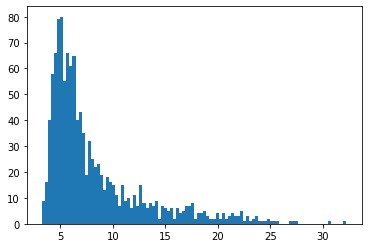

In [4]:
d = annotations_df['diameter_mm'].values
fig = plt.hist(d, bins=100)

In [5]:
annotations_df = annotations_df[annotations_df['diameter_mm']>=3.9]     # Excluding nodules with diameter less than 3.9mm
print(len(annotations_df))

1149


In [6]:
def load_image(file):
    image_itk = sitk.ReadImage(file)
    image_itk = sitk.IntensityWindowing(image_itk, 
                                        windowMinimum=-1000, windowMaximum=400, 
                                        outputMinimum=0.0, outputMaximum=255.0)
    image_itk = sitk.Cast(image_itk, sitk.sitkUInt8)
    image_arr = sitk.GetArrayFromImage(image_itk)
    origin = np.array(list(image_itk.GetOrigin()))
    space = np.array(list(image_itk.GetSpacing()))
    return image_arr, origin, space

def load_mask(file):
    mask_itk = sitk.ReadImage(file)
    mask_arr = sitk.GetArrayFromImage(mask_itk)
    return mask_arr

def make_mask(image, center, diam):
    mask = np.zeros_like(image, dtype=np.uint8)
    mask = cv2.circle(mask, (abs(int(center[0])),abs(int(center[1]))),int(abs(diam//2)), 255, -1)
    return mask

def make_body_mask(image):
    _, body_mask = cv2.threshold(image,127,255,cv2.THRESH_BINARY)
    body_mask = ndimage.binary_fill_holes(body_mask).astype(int)

    labels_mask = measure.label(body_mask)                       
    regions = measure.regionprops(labels_mask)
    regions.sort(key=lambda x: x.area, reverse=True)
    if len(regions) > 1:
        for rg in regions[1:]:
            labels_mask[rg.coords[:,0], rg.coords[:,1]] = 0
    labels_mask[labels_mask!=0] = 1
    return labels_mask

# label_to_color = {
#     0: [  0,   0,   0],
#     1: [ 34,  80, 242],
#     2: [  0, 186, 127],
#     3: [  239, 164, 0],
#     4: [  0, 185, 255],
#     5: [115, 115, 115],
# }

label_to_color = {
    0: [  0,   0,   0],
    1: [242,  80,  34],
    2: [127, 186,   0],
    3: [  0, 164, 239],
    4: [255, 185,   0],
    5: [115, 115, 115],
}


In [ ]:
!mkdir -p LUNA16/images LUNA16/labels_ohe LUNA16/labels_rgb LUNA16/nodule_images LUNA16/nodule_labels_ohe LUNA16/nodule_labels_rgb

In [8]:
for i, seriesuid in tqdm(enumerate(annotations_df['seriesuid'].unique()), total=len(annotations_df['seriesuid'].unique())):
    
#     print(seriesuid)
    
#     if i == 4: 
#         break
    
    annotations = annotations_df[annotations_df['seriesuid']==seriesuid]
    image_arr, origin, space = load_image(os.path.join(root, f'images/{seriesuid}.mhd'))      # Loading the CT scan
    num_z, height, width = image_arr.shape
    mask_arr = load_mask(os.path.join(root, f'seg-lungs-LUNA16/{seriesuid}.mhd'))

    lung_slice_idx = np.any(mask_arr, axis=(1,2))


    for ii, row in annotations.iterrows():

        node_x = row["coordX"]     # X coordinate of the nodule
        node_y = row["coordY"]     # Y coordinate of the nodule
        node_z = row["coordZ"]     # Z coordinate of the nodule
        diam = row["diameter_mm"]  # Diameter of the nodule

        center = np.array([node_x, node_y, node_z])                 # nodule center (x,y,z ordering)
        v_center = np.rint((center-origin)/space).astype('int')     # nodule center in voxel space (x,y,z ordering)
        v_diam = np.ceil((diam/space)).astype('int')                # Diameter of nodule in voxel space

        min_i = max(0,(int(v_center[2]-v_diam[2]//2)))
        max_i = min((int(v_center[2]+v_diam[2]//2)),(num_z-2))

        lung_slice_idx[min_i:max_i+1] = False  # Lung slices that are nodule free
        
        idx = int(v_center[2])  # slice idx centered on nodule

        image_slice = image_arr[idx]    
        # lung_roi_mask = (cv2.dilate(mask_arr[idx], kernel=np.ones((12,12))) > 0).astype('uint8')   
        l_lung_mask = (mask_arr[idx]==3).astype('uint8')   
        r_lung_mask = (mask_arr[idx]==4).astype('uint8')   
        trachea_mask = (mask_arr[idx]==5).astype('uint8')   
        body_mask = make_body_mask(image_slice)

        nodule_mask = make_mask(image_slice, v_center, v_diam[0])    # Creating a mask of the nodule

        # Calculating the threshold value for extracting the nodule mask using binary thresholding
        nodule_mask = cv2.bitwise_and(image_slice, image_slice, mask=cv2.dilate(nodule_mask, kernel=np.ones((5,5))))
        pts = nodule_mask[nodule_mask>0]
        kmeans2 = KMeans(n_clusters=2).fit(np.reshape(pts,(len(pts),1)))
        centroids2 = sorted(kmeans2.cluster_centers_.flatten())
        threshold2 = np.mean(centroids2)
        _, nodule_mask = cv2.threshold(nodule_mask, threshold2, 1, cv2.THRESH_BINARY)
        
        total_mask = np.stack([np.zeros((512,512)), body_mask, l_lung_mask*2, r_lung_mask*3, trachea_mask*4, nodule_mask*5], axis=-1)
        total_mask = np.argmax(total_mask, axis=-1)
        
        label_rgb = np.zeros((512, 512, 3), dtype=np.uint8)
        for gray, rgb in label_to_color.items():
            label_rgb[total_mask == gray, :] = rgb
        
        cv2.imwrite(f'./LUNA16/nodule_images/{seriesuid}_{idx}.png', image_slice)
        cv2.imwrite(f'./LUNA16/nodule_labels_ohe/{seriesuid}_{idx}.png', total_mask)
        cv2.imwrite(f'./LUNA16/nodule_labels_rgb/{seriesuid}_{idx}.png', label_rgb)

    for ii in range(0, len(lung_slice_idx)):
    
        if lung_slice_idx[ii] == False:
            continue

        image_slice = image_arr[ii]    
        # lung_roi_mask = (cv2.dilate(mask_arr[ii], kernel=np.ones((12,12))) > 0).astype('uint8')
        l_lung_mask = (mask_arr[ii]==3).astype('uint8')   
        r_lung_mask = (mask_arr[ii]==4).astype('uint8')   
        trachea_mask = (mask_arr[ii]==5).astype('uint8')   
        body_mask = make_body_mask(image_slice)
        
        total_mask = np.stack([np.zeros((512,512)), body_mask, l_lung_mask*2, r_lung_mask*3, trachea_mask*4], axis=-1)
        total_mask = np.argmax(total_mask, axis=-1)
        
        label_rgb = np.zeros((512, 512, 3), dtype=np.uint8)
        for gray, rgb in label_to_color.items():
            label_rgb[total_mask == gray, :] = rgb
        
        cv2.imwrite(f'./LUNA16/images/{seriesuid}_{ii}.png', image_slice)
        cv2.imwrite(f'./LUNA16/labels_ohe/{seriesuid}_{ii}.png', total_mask)
        cv2.imwrite(f'./LUNA16/labels_rgb/{seriesuid}_{ii}.png', label_rgb)




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 591/591 [2:54:39<00:00, 17.73s/it]
